# 基于模板匹配的车牌识别

## 1 项目准备

In [1]:
# 导入所需模块
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np

In [2]:
# 定义必要函数

# 显示图片
def cv_show(name, img):
    cv2.imshow(name, img)
    cv2.waitKey()
    cv2.destroyAllWindows()


# plt 显示彩色图片
def plt_show0(img):
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    plt.imshow(img)
    plt.show()


# plt 显示灰度图片
def plt_show(img):
    plt.imshow(img, cmap='gray')
    plt.show()

# 图像去噪和灰度处理
def gray_gauss(image):
    image = cv2.GaussianBlur(image, (3,3), 0)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

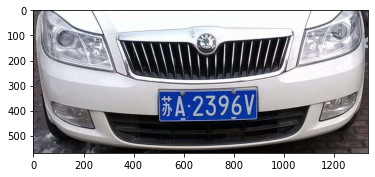

In [3]:
# 读取待检测图片
filename = "car3.jpeg"
origin_image = cv2.imread("./images/" + filename)
plt_show0(origin_image)

## 2 提取图像车牌部分

In [4]:
xxx = 0
yyy = 0

In [5]:
# 提取图片车牌部分
def get_license_plate(image):
    gray_image = gray_gauss(image)
    # sobel算子边缘检测
    Sobel_x = cv2.Sobel(gray_image, cv2.CV_16S, 1, 0)
    absX = cv2.convertScaleAbs(Sobel_x)
    image = absX
    # 自适应阈值处理
    ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
    
    # 闭运算, 将白色的地方变成整体, 先膨胀再腐蚀
    kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 5))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernelX, iterations=3)
    
    # 去除细小的白色区域
    kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    kernelY = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 19))
    # 膨胀, 腐蚀
    image = cv2.dilate(image, kernelX)
    image = cv2.erode(image, kernelX)
    # 腐蚀, 膨胀
    image = cv2.erode(image,kernelY)
    image = cv2.dilate(image, kernelY)

    # 中值滤波去除噪点
    image = cv2.medianBlur(image, 15)

    # 轮廓检测
    # cv2.RETR_EXTERNAL 表示只检测外轮廓
    # cv2.CHAIN_APPROX_SIMPLE 压缩水平方向, 垂直方向, 对角线方向的元素, 只保留该方向的终点坐标
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 筛选出车牌位置的轮廓
    # 轮廓长宽比介于3:1和4:1之间
    for item in contours:
        # cv2.boundingRect用一个最小的矩形, 把找到的形状包起来
        rect = cv2.boundingRect(item)
        x = rect[0]
        y = rect[1]
        width = rect[2]
        height = rect[3]
        if (height * 3) < width < (height * 4):
            image = origin_image[y:y+height, x:x + width]
            return image

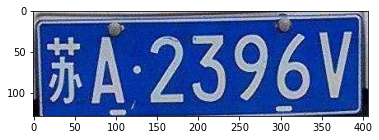

In [6]:
image = origin_image.copy()
carLicense_image = get_license_plate(image)
plt_show0(carLicense_image)

## 3 车牌字符分割

In [7]:
def car_license_split(image):
    gray_image = gray_gauss(image)
    ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
    plt_show(image)
    # 计第二值图像黑白点的个数，让车牌号码为白色
    area_white = 0
    area_black = 0
    height, width = image.shape
    print(image.shape)
    for i in range(height):
        for j in range(width):
            if image[i, j] == 255:
                area_white += 1
            else:
                area_black += 1
    if area_white > area_black:
        ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
        plt_show(image)

    # 膨胀,让分开的字连一起方便定位的时候不会分开
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    image = cv2.dilate(image, kernel)
    # 轮廓检测
    # cv2.RETR_EXTERNAL 表示只检测外轮廓
    # cv2.CHAIN_APPROX_SIMPLE 压缩水平方向, 垂直方向, 对角线方向的元素, 只保留该方向的重点坐标
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 筛选出字符位置的轮廓
    words = []
    word_images = []
    for item in contours:
        rect = cv2.boundingRect(item)
        x = rect[0]
        y = rect[1]
        width = rect[2]
        height = rect[3]
        word = [x, y, width, height]
        words.append(word)
    words = sorted(words, key = lambda s:s[0], reverse=False)
    i = 0
    for word in words:
        if (word[2] * 1.8) < word[3] < (word[2] * 3.5):
            i += 1
            splite_image = image[word[1]:word[1] + word[3], word[0]:word[0] + word[2]]
            word_images.append(splite_image)
    return word_images


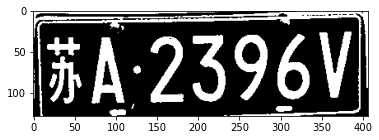

(128, 407)


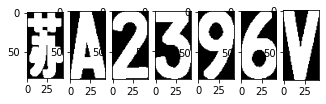

In [8]:
image = carLicense_image.copy()
word_images = car_license_split(image)

# 绿牌和蓝牌子图参数不同,绿牌是8, 蓝牌是7
for i, j in enumerate(word_images):
    plt.subplot(1, 8, i+1)
    plt.imshow(word_images[i], cmap='gray')
plt.show()

## 4 模板匹配

In [9]:
# 准备模板
template = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
            'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M',
            'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
            '藏', '川', '鄂', '甘', '赣', '贵', '桂', '黑',
            '沪', '吉', '冀', '津', '晋', '京', '辽', '鲁',
            '蒙', '闽', '宁', '青', '琼', '陕', '苏', '皖',
            '湘', '新', '渝', '豫', '粤', '云', '浙']

# 读取一个文件夹下的全部图片, 输入参数是文件名, 返回文件地址列表
def read_directory(directory_name):
    referImg_list = []
    for file_name in os.listdir(directory_name):
        referImg_list.append(directory_name + "/" + file_name)
    return referImg_list

# 中文模板匹配(用来匹配省份代码)
def get_chinese_words_list():
    chinese_words_list = []
    for i in range(34, 64):
        c_word = read_directory('./refer/' + template[i])
        chinese_words_list.append(c_word)
    return chinese_words_list
chinese_words_list = get_chinese_words_list()

# 英文模板匹配(用来匹配车牌地级市代号)
def get_english_words_list():
    english_words_list = []
    for i in range(10, 34):
        e_word = read_directory('./refer/' + template[i])
        english_words_list.append(e_word)
    return english_words_list
english_words_list = get_english_words_list()

# 非汉字模板匹配
def get_eng_num_words_list():
    eng_num_words_list = []
    for i in range(0, 34):
        word = read_directory('./refer/' + template[i])
        eng_num_words_list.append(word)
    return eng_num_words_list
eng_num_words_list = get_eng_num_words_list()

# 读取一个模板地址与图片进行匹配, 返回得分
def template_score(template, image):
    template_img = cv2.imdecode(np.fromfile(template, dtype=np.uint8), 1)
    template_img = cv2.cvtColor(template_img,cv2.COLOR_RGB2GRAY)
    ret, template_img = cv2.threshold(template_img, 0, 255, cv2.THRESH_OTSU)
    
    image_ = image.copy()
    height, width = image_.shape
    template_img = cv2.resize(template_img, (width, height))
    result = cv2.matchTemplate(image_, template_img, cv2.TM_CCOEFF)
    return result[0][0]
    
    

In [10]:
def template_matching(word_images):
    results = []
    for index, word_image in enumerate(word_images):
        if index == 0:
            best_score = []
            for chinese_word_list in chinese_words_list:
                score = []
                for chinese_word in chinese_word_list:
                    result = template_score(chinese_word, word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            
            r = template[34+i]
            results.append(r)
            continue
        if index == 1:
            best_score = []
            for eng_word_list in english_words_list:
                score = []
                for eng_word in eng_word_list:
                    result = template_score(eng_word, word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            
            r = template[10+i]
            results.append(r)
            continue
        else:
            best_score = []
            for eng_num_word_list in eng_num_words_list:
                score = []
                for eng_num_word in eng_num_word_list:
                    result = template_score(eng_num_word, word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            
            r = template[i]
            results.append(r)
            continue
    return results

In [11]:
word_images_ = word_images.copy()
result = template_matching(word_images_)
print("".join(result))

苏A2396V


## 5 结果渲染

In [12]:
height,weight = origin_image.shape[0:2]
print(height)
print(weight)

569
1337


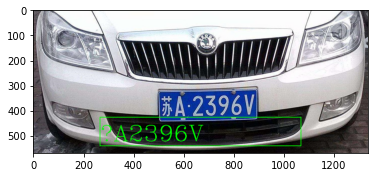

In [13]:
# 在原图中显示结果
image = origin_image.copy()
cv2.rectangle(image, (int(0.2*weight), int(0.75*height)), (int(weight*0.8), int(height*0.95)), (0,255,0),2)
cv2.putText(image,"".join(result), (int(0.2*weight), int(0.75*height+height/6)), cv2.FONT_HERSHEY_COMPLEX, 3, (0,255,0),2)
plt_show0(image)